# Classify Lego **Project**

Based on **Patric Loeber** video: https://www.youtube.com/watch?v=LwM7xabuiIc&t=7916s

## Dataset

https://www.kaggle.com/datasets/ihelon/lego-minifigures-classification


This dataset contains a lot of pictures of various LEGO Minifigures.
There are several images in different poses or with different environments for each Minifigure in the dataset. You can use this dataset for the image classification tasks or try to create more interesting things. Y

In [5]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [6]:
BASE_DIR = 'data_lego/star-wars-images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [7]:
# Read information about dataset
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [ ]:
#  Total number of classes in the dataset
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images * 0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

### Data augmentation

https://www.tensorflow.org/tutorials/images/data_augmentation

Data augmentation is a technique to increase the diversity of your training set by applying random (but realistic) transformation such as image rotation. We are doing it only for our training set.

In [38]:
# Generate batches of tensor image data with real-time data augmentation

# preprocessing function
# rescale = 1. / 255 -> images in the range between o and 1
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#,
#                                                        rotation_range=20,
#                                                        horizontal_flip=True,
#                                                        width_shift_range=0.2, height_shift_range=0.2,
#                                                        shear_range=0.2, zoom_range=0.2)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'data_lego/star-wars-images/train',
    target_size=(256,256), # if we specify a target size then tensorflow is automatically resizing images for us
    class_mode='sparse', # we want to have labels as a single integer value 
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

valid_batches = valid_gen.flow_from_directory(
    'data_lego/star-wars-images/val',
    target_size=(256,256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'data_lego/star-wars-images/test',
    target_size=(256,256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [39]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])

test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[2. 2. 4. 1.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


In [40]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays,
        # which is why we need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show


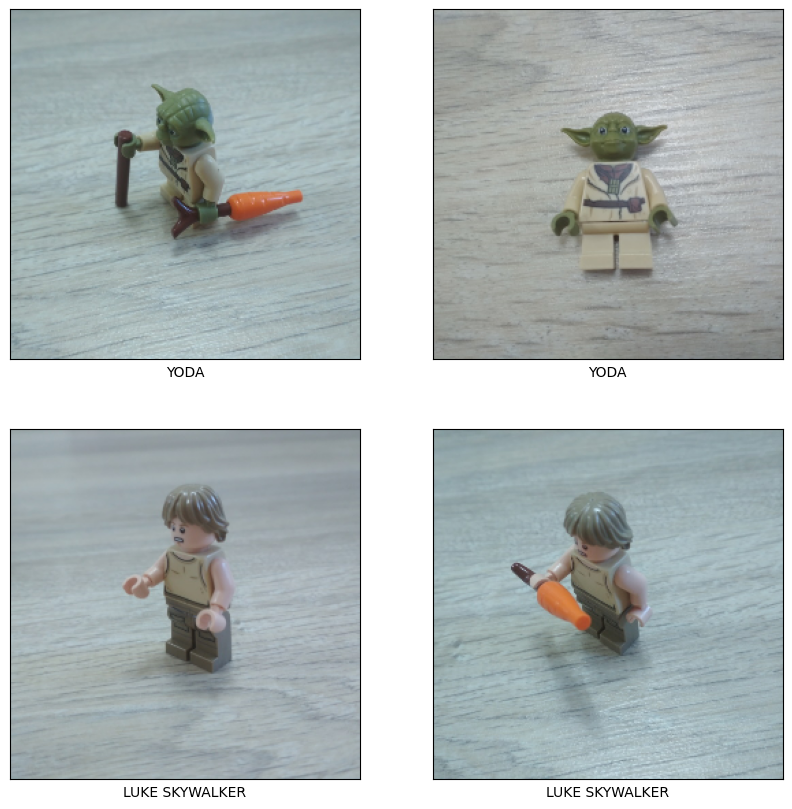

In [41]:
show(test_batch)

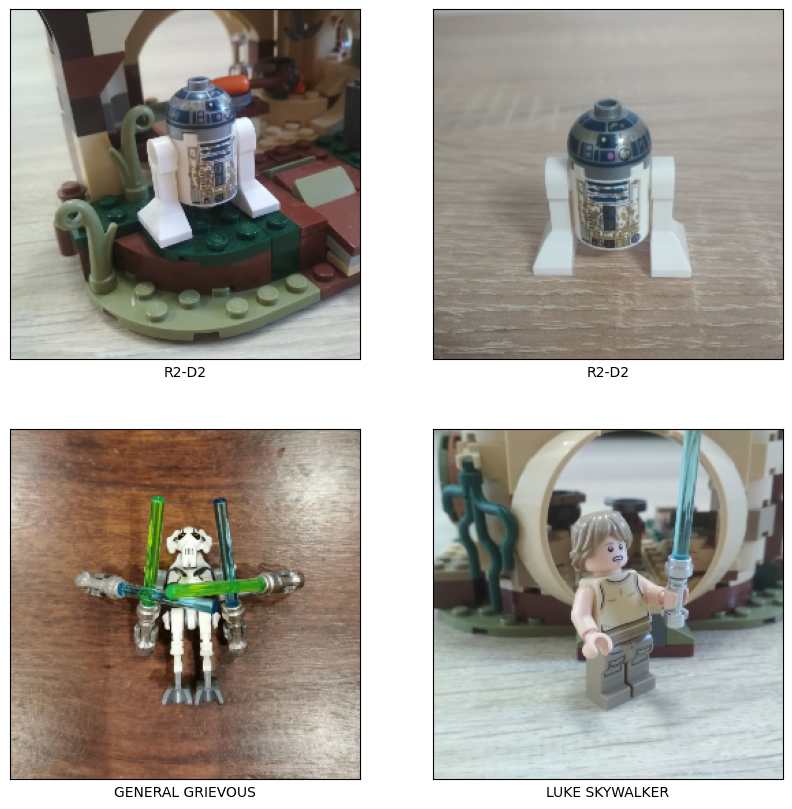

In [42]:
show(train_batch)

In [43]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 246016)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [44]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.legacy.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

### Keras callbacks

Callback is a function tat is applied after each training epoch. Here we can for example save checkpoints or use diffefrent things. We want to use there an early stopping callback.

In [45]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5, # if the validation loss does not improve for the next 5 epochs then it will automatically do an early stopping of our training.
    verbose=2
)

history = model.fit(train_batches, validation_data=valid_batches,
                    callbacks=[early_stopping],
                    epochs=epochs, verbose=2)

Epoch 1/30


2023-05-21 14:00:27.161785: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 - 1s - loss: 6.2759 - accuracy: 0.1622 - val_loss: 1.6473 - val_accuracy: 0.2500 - 930ms/epoch - 93ms/step
Epoch 2/30


2023-05-21 14:00:27.977678: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 - 1s - loss: 1.6154 - accuracy: 0.2973 - val_loss: 1.5853 - val_accuracy: 0.2500 - 734ms/epoch - 73ms/step
Epoch 3/30
10/10 - 1s - loss: 1.0606 - accuracy: 0.6757 - val_loss: 1.3230 - val_accuracy: 0.3750 - 730ms/epoch - 73ms/step
Epoch 4/30
10/10 - 1s - loss: 0.6492 - accuracy: 0.8108 - val_loss: 1.1413 - val_accuracy: 0.5625 - 736ms/epoch - 74ms/step
Epoch 5/30
10/10 - 1s - loss: 0.3398 - accuracy: 0.8919 - val_loss: 1.7480 - val_accuracy: 0.4375 - 733ms/epoch - 73ms/step
Epoch 6/30
10/10 - 1s - loss: 0.2352 - accuracy: 0.9189 - val_loss: 1.6294 - val_accuracy: 0.4375 - 730ms/epoch - 73ms/step
Epoch 7/30
10/10 - 1s - loss: 0.1793 - accuracy: 0.9459 - val_loss: 1.6456 - val_accuracy: 0.5000 - 733ms/epoch - 73ms/step
Epoch 8/30
10/10 - 1s - loss: 0.1281 - accuracy: 0.9730 - val_loss: 1.5580 - val_accuracy: 0.5625 - 726ms/epoch - 73ms/step
Epoch 9/30
10/10 - 1s - loss: 0.0936 - accuracy: 0.9730 - val_loss: 2.3271 - val_accuracy: 0.5000 - 723ms/epoch - 72ms/step
Epoch 9: early stop

We encounter here overfitting problem due to lack of images.

In [46]:
model.save("lego_model.h5")

/Users/florian/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


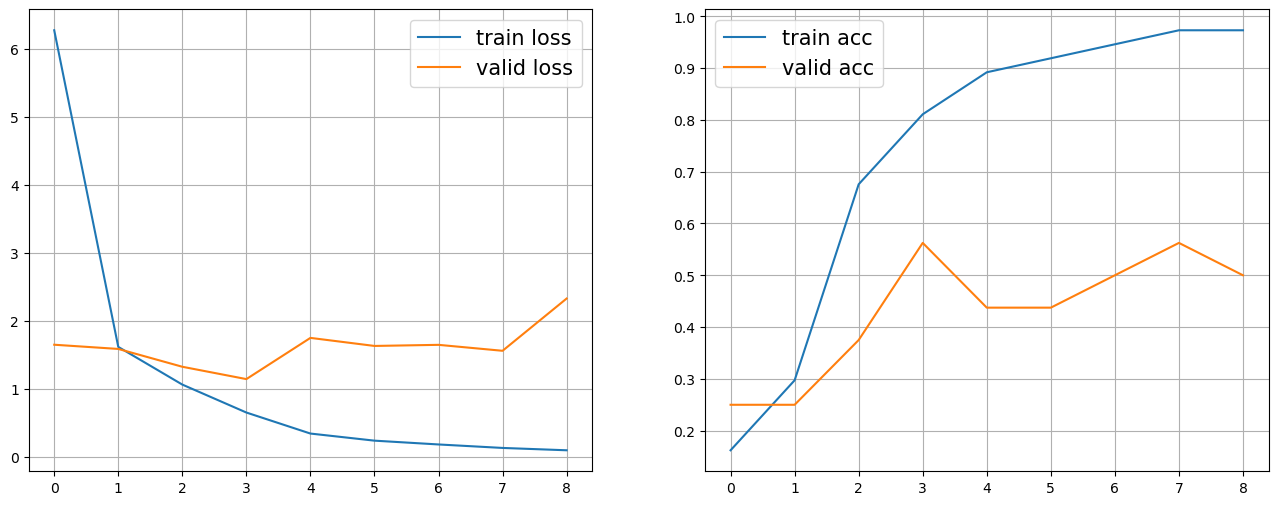

In [47]:
# plot loss and acc
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15)

In [48]:
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 2.8586 - accuracy: 0.4000 - 69ms/epoch - 23ms/step


2023-05-21 14:00:54.655142: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


[2.8586299419403076, 0.4000000059604645]

In [49]:
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 0s 14ms/step
[0. 0. 1. 1.]
[1 1 1 1]


2023-05-21 14:03:24.274520: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


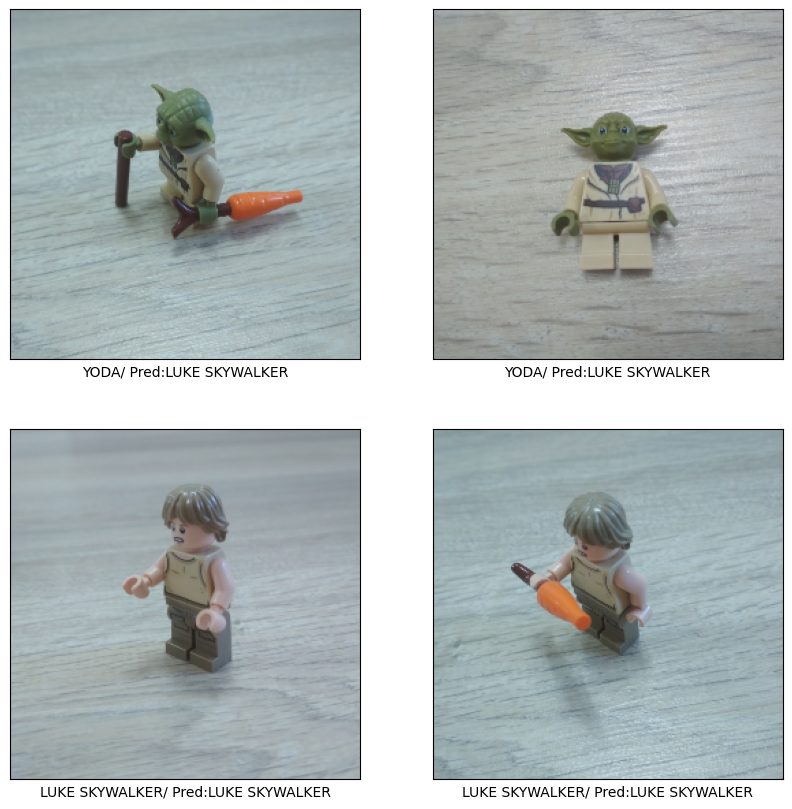

In [50]:
show(test_batches[0], labels[0:4])

# Transfer learning

Based on Patric Loeber video: https://www.youtube.com/watch?v=LwM7xabuiIc&t=9152s

## Concept

The concept is that we use a model that has been already trained and this is probably a very good model with a lot of features and that also has been trained on a lot of data. What we do is we take this trained model and then we only modify the last layers. We cut them out and then apply our own classification layers at the end. We train only these layers at the end. With this our training can be very quick but we can also get the power of the rest of the neural network that is already pre-trained.

In [61]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

# another pre trained net - MobilenetV2
#tl_model = tf.keras.applications.MobileNetV2()
#print(type(tl_model))
#tl_model.summary()

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<class 'keras.src.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool

In [62]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [64]:
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [65]:
model.add(layers.Dense(5))

In [66]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.legacy.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [67]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [68]:
# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'data_lego/star-wars-images/train',
    target_size=(224,224), # if we specify a target size then tensorflow is automatically resizing images for us
    class_mode='sparse', # we want to have labels as a single integer value 
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

valid_batches = valid_gen.flow_from_directory(
    'data_lego/star-wars-images/val',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'data_lego/star-wars-images/test',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [69]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5, # if the validation loss does not improve for the next 5 epochs then it will automatically do an early stopping of our training.
    verbose=2
)

model.fit(train_batches, validation_data=valid_batches,
                    callbacks=[early_stopping],
                    epochs=epochs, verbose=2)

Epoch 1/30


2023-05-21 14:47:16.173232: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 14:47:19.796846: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 - 5s - loss: 1.4042 - accuracy: 0.4865 - val_loss: 0.8090 - val_accuracy: 0.6875 - 5s/epoch - 519ms/step
Epoch 2/30
10/10 - 5s - loss: 0.1912 - accuracy: 0.9730 - val_loss: 0.3513 - val_accuracy: 0.8750 - 5s/epoch - 497ms/step
Epoch 3/30
10/10 - 5s - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.2725 - val_accuracy: 0.8750 - 5s/epoch - 509ms/step
Epoch 4/30
10/10 - 5s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.2474 - val_accuracy: 0.8750 - 5s/epoch - 516ms/step
Epoch 5/30
10/10 - 5s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2423 - val_accuracy: 0.8750 - 5s/epoch - 518ms/step
Epoch 6/30
10/10 - 5s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2454 - val_accuracy: 0.8750 - 5s/epoch - 518ms/step
Epoch 7/30
10/10 - 5s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2487 - val_accuracy: 0.8750 - 5s/epoch - 520ms/step
Epoch 8/30
10/10 - 5s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.8750 - 5s/epoch - 526ms/step
Epoch 9/30
10/10 - 5s - loss: 0.001

In [70]:
model.evaluate(test_batches, verbose=2)

2023-05-21 14:48:55.244105: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 - 1s - loss: 0.0405 - accuracy: 1.0000 - 991ms/epoch - 330ms/step


[0.04053892940282822, 1.0]